#### QUESTIONS
1. What is padding, output_padding in nn.ConvTranspose2d?
2. What is ReflectionPad2d v.s. ReplicationPad2d?
3. [fastai] transform is applied on tensor or PIL.Image?

#### REFERENCE
1. fastai notebook on CycleGAN: https://github.com/fastai/course-v3/blob/master/nbs/dl2/cyclegan.ipynb

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from fastai.vision import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
path = Path('../data/horse2zebra/horse2zebra')
path.ls()

[PosixPath('../data/horse2zebra/horse2zebra/trainB'),
 PosixPath('../data/horse2zebra/horse2zebra/trainA'),
 PosixPath('../data/horse2zebra/horse2zebra/testB'),
 PosixPath('../data/horse2zebra/horse2zebra/testA')]

#### 1. Dataset

In [3]:
class ImageTuple(ItemBase):
    def __init__(self, img1, img2):
        # img1, img2 = fastai.vision.image.Imagae
        self.img1,self.img2 = img1,img2
        # img.data is [0 - 1] tensor, converted to [-0.5 - 0.5]
        self.obj,self.data = (img1,img2),[-1+2*img1.data,-1+2*img2.data]
    
    def apply_tfms(self, tfms, **kwargs):
        self.img1 = self.img1.apply_tfms(tfms, **kwargs)
        self.img2 = self.img2.apply_tfms(tfms, **kwargs)
        return self
    
    def to_one(self): return Image(0.5+torch.cat(self.data,2)/2)

In [4]:
class TargetTupleList(ItemList):
    def reconstruct(self, t:Tensor): 
        if len(t.size()) == 0: return t
        # Image input is tensor (C, H, W) -- [0-1]
        return ImageTuple(Image(t[0]/2+0.5),Image(t[1]/2+0.5))

In [5]:
class ImageTupleList(ImageList):
    _label_cls=TargetTupleList
    def __init__(self, items, itemsB=None, **kwargs):
        self.itemsB = itemsB
        super().__init__(items, **kwargs)
    
    def new(self, items, **kwargs):
        return super().new(items, itemsB=self.itemsB, **kwargs)
    
    def get(self, i):
        img1 = super().get(i)
        fn = self.itemsB[random.randint(0, len(self.itemsB)-1)]
        return ImageTuple(img1, open_image(fn))
    
    def reconstruct(self, t:Tensor): 
        return ImageTuple(Image(t[0]/2+0.5),Image(t[1]/2+0.5))
    
    @classmethod
    def from_folders(cls, path, folderA, folderB, **kwargs):
        itemsB = ImageList.from_folder(path/folderB).items
        res = super().from_folder(path/folderA, itemsB=itemsB, **kwargs)
        res.path = path
        return res
    
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(12,6), **kwargs):
        "Show the `xs` and `ys` on a figure of `figsize`. `kwargs` are passed to the show method."
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].to_one().show(ax=ax, **kwargs)
        plt.tight_layout()

    def show_xyzs(self, xs, ys, zs, figsize:Tuple[int,int]=None, **kwargs):
        """Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`.
        `kwargs` are passed to the show method."""
        figsize = ifnone(figsize, (12,3*len(xs)))
        fig,axs = plt.subplots(len(xs), 2, figsize=figsize)
        fig.suptitle('Ground truth / Predictions', weight='bold', size=14)
        for i,(x,z) in enumerate(zip(xs,zs)):
            x.to_one().show(ax=axs[i,0], **kwargs)
            z.to_one().show(ax=axs[i,1], **kwargs)

In [6]:
data = (ImageTupleList.from_folders(path, 'trainA', 'trainB')
                      .split_none()
                      .label_empty()
                      .transform(get_transforms(), size=128)
                      .databunch(bs=4))

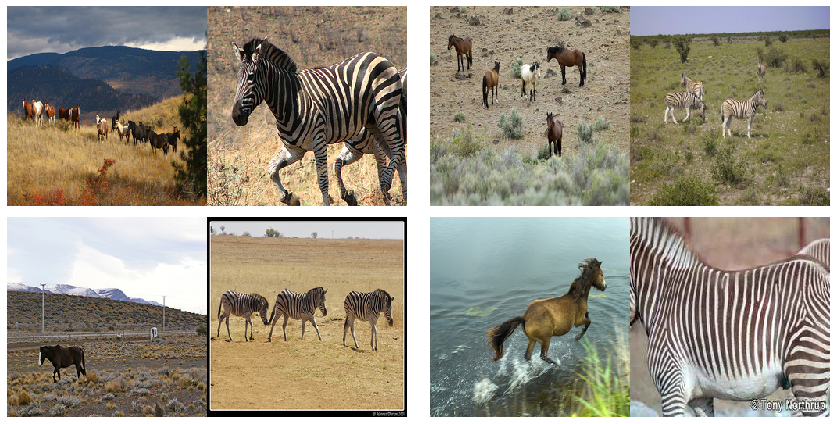

In [7]:
data.show_batch(rows = 2)

#### 2a. Model Components

In [8]:
def conv_t_norm_relu(ch_in, ch_out, norm_layer, ks = 3, stride = 2, bias = True):
    conv_t = nn.ConvTranspose2d(ch_in, ch_out, kernel_size = ks, stride = stride, 
                                padding = 1, output_padding = 1, bias = bias)
    return [conv_t, norm_layer(ch_out), nn.ReLU(True)]

In [9]:
def pad_conv_norm_relu(ch_in, ch_out, pad_mode, norm_layer, ks = 3, bias = True,
                        pad = 1, stride = 1, activ = True, init = nn.init.kaiming_normal_):
    layers = []
    if pad_mode == 'reflection':
        layers.append(nn.ReflectionPad2d(pad))
    elif pad_mode == 'border':
        layers.append(nn.ReplicationPad2d(pad))
    p = pad if pad_mode == 'zeros' else 0
    # same padding
    conv = nn.Conv2d(ch_in, ch_out, kernel_size = 3, padding = p, stride = stride, bias = bias)
    if init:
        init(conv.weight)
        if hasattr(conv, 'bias') and hasattr(conv.bias, 'data'): conv.bias.data.fill_(0.)
    layers += [conv, norm_layer(ch_out)]
    if activ: layers.append(nn.ReLU(True))
    return layers

In [10]:
class ResnetBlock(nn.Module):
    def __init__(self, dim, pad_mode, norm_layer, dropout = 0., bias = True):
        super().__init__()
        assert pad_mode in ['zeros', 'reflection', 'border'], f'padding {pad_mode} not implemented'
        norm_layer = ifnone(norm_layer, nn.InstanceNorm2d)
        layers = pad_conv_norm_relu(dim, dim, pad_mode, norm_layer, bias = bias)
        if dropout != 0: 
            layers.append(nn.Dropout(dropout))
        layers += pad_conv_norm_relu(dim, dim, pad_mode, norm_layer, bias = bias, activ = False)
        self.conv_block = nn.Sequential(*layers)
    
    def forward(self, x):
        return x + self.conv_block(x)

In [11]:
def resnet_generator(ch_in, ch_out, n_ftrs = 64, norm_layer = None, 
                     dropout = 0., n_blocks = 6, pad_mode = 'reflection'):
    norm_layer = ifnone(norm_layer, nn.InstanceNorm2d)
    bias = (norm_layer == nn.InstanceNorm2d)
    layers = pad_conv_norm_relu(ch_in, n_ftrs, 'reflection', norm_layer, pad = 3, ks = 7, bias = bias)
    for i in range(2):
        layers += pad_conv_norm_relu(n_ftrs, n_ftrs * 2, 'zeros', norm_layer, stride = 2, bias = bias)
        n_ftrs *= 2
    layers += [ResnetBlock(n_ftrs, pad_mode, norm_layer, dropout, bias) for _ in range(n_blocks)]
    for i in range(2):
        layers += conv_t_norm_relu(n_ftrs, n_ftrs // 2, norm_layer, bias = bias)
        n_ftrs //= 2
    layers += [nn.ReflectionPad2d(3), nn.Conv2d(n_ftrs, ch_out, kernel_size = 7, padding = 0), nn.Tanh()]
    return nn.Sequential(*layers)

In [12]:
resnet_generator(3, 3)

Sequential(
  (0): ReflectionPad2d((3, 3, 3, 3))
  (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (3): ReLU(inplace=True)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (8): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (9): ReLU(inplace=True)
  (10): ResnetBlock(
    (conv_block): Sequential(
      (0): ReflectionPad2d((1, 1, 1, 1))
      (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (2): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (3): ReLU(inplace=True)
      (4): ReflectionPad2d((1, 1, 1, 1))
      (5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    

In [13]:
def conv_norm_lr(ch_in, ch_out, norm_layer = None, ks = 3, 
                  bias = True, pad = 1, stride = 1, activ = True,
                  slope = 0.2, init = nn.init.kaiming_normal_):
    conv = nn.Conv2d(ch_in, ch_out, kernel_size = ks, 
                     padding = pad, stride = stride, bias = bias)
    if init:
        # change in-place
        init(conv.weight)
        if hasattr(conv, 'bias') and hasattr(conv.bias, 'data'): conv.bias.data.fill_(0.)
    layers = [conv]
    if norm_layer is not None: layers.append(norm_layer(ch_out))
    if activ: layers.append(nn.LeakyReLU(slope, inplace = True))
    return layers

In [14]:
def discriminator(ch_in, n_ftrs = 64, n_layers = 3, 
                   norm_layer = None, sigmoid = False):
    norm_layer = ifnone(norm_layer, nn.InstanceNorm2d)
    bias = (norm_layer == nn.InstanceNorm2d)
    layers = conv_norm_lr(ch_in, n_ftrs, ks = 4, stride = 2, pad = 1)
    for i in range(n_layers - 1):
        new_ftrs = 2 * n_ftrs if i <= 3 else n_ftrs
        layers += conv_norm_lr(n_ftrs, new_ftrs, norm_layer, 
                               ks = 4, stride = 2, pad = 1, bias = bias)
        n_ftrs = new_ftrs
    new_ftrs = 2 * n_ftrs if n_layers <= 3 else n_ftrs
    layers += conv_norm_lr(n_ftrs, new_ftrs, norm_layer, 
                           ks = 4, stride = 1, pad = 1, bias = bias)
    layers.append(nn.Conv2d(new_ftrs, 1, kernel_size = 4, stride = 1, padding = 1))
    if sigmoid: layers.append(nn.Sigmoid)
    return nn.Sequential(*layers)

In [15]:
discriminator(3)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (1): LeakyReLU(negative_slope=0.2, inplace=True)
  (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (4): LeakyReLU(negative_slope=0.2, inplace=True)
  (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (7): LeakyReLU(negative_slope=0.2, inplace=True)
  (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (10): LeakyReLU(negative_slope=0.2, inplace=True)
  (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
)

#### 2b. Integrate All as CycleGAN

#### 3. Define Loss Function